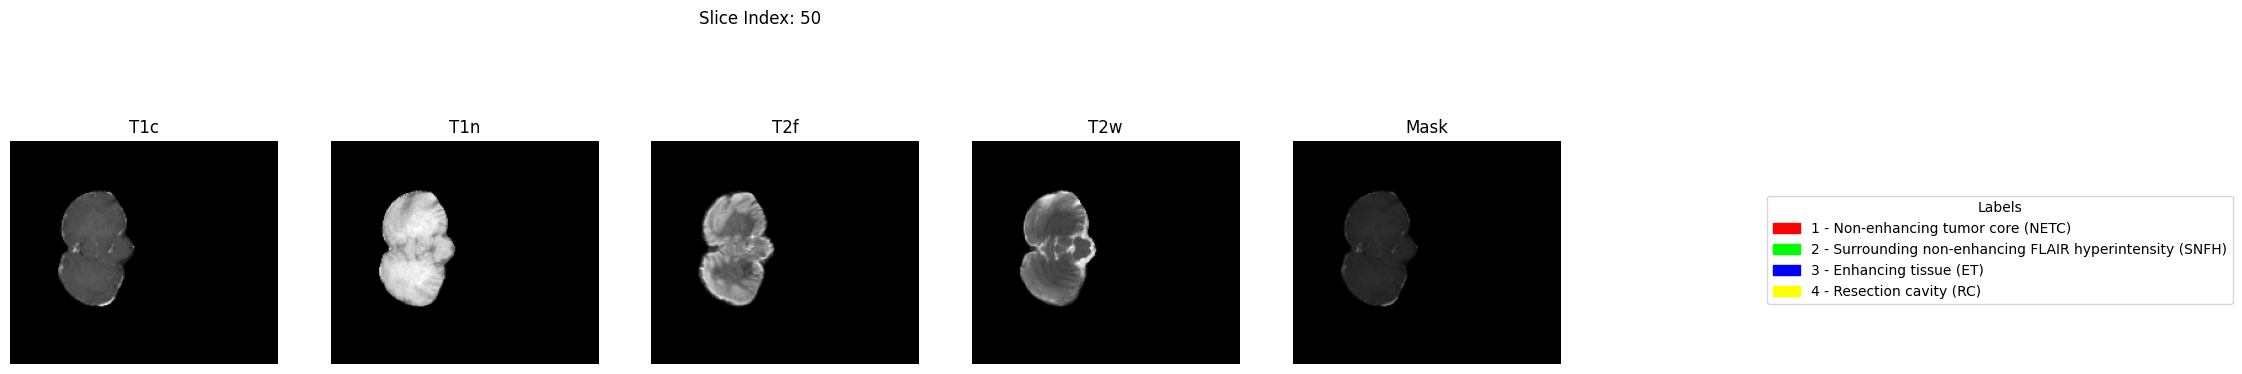

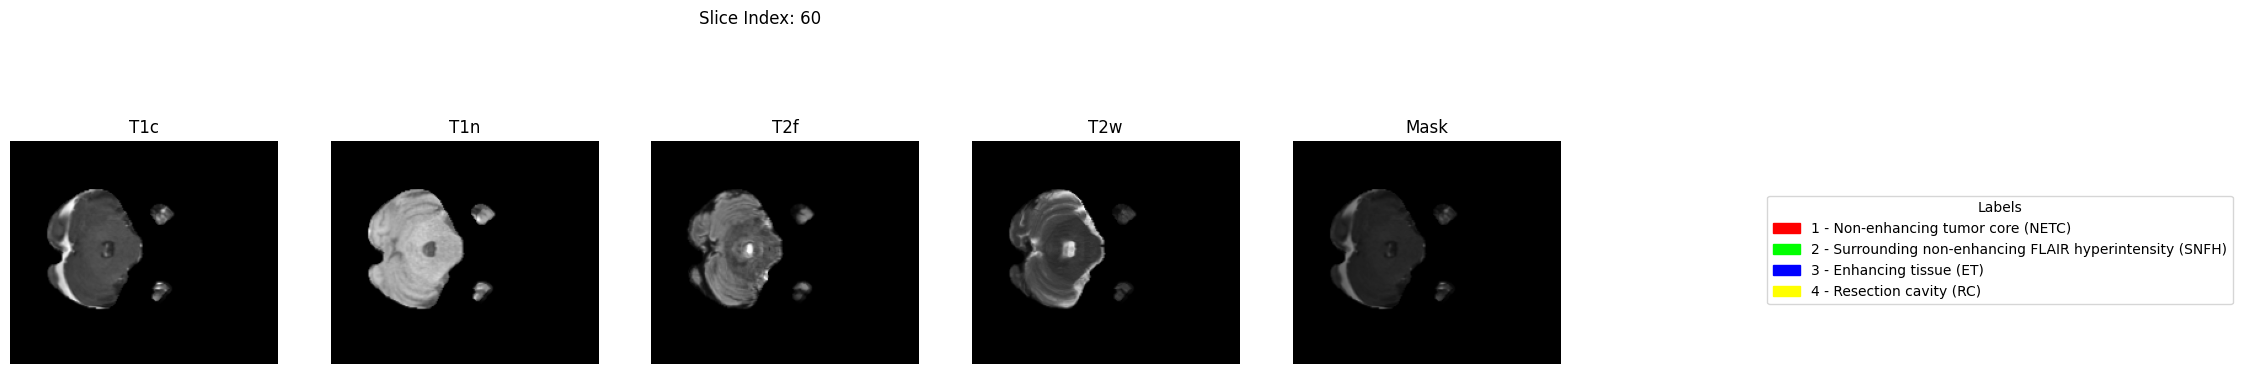

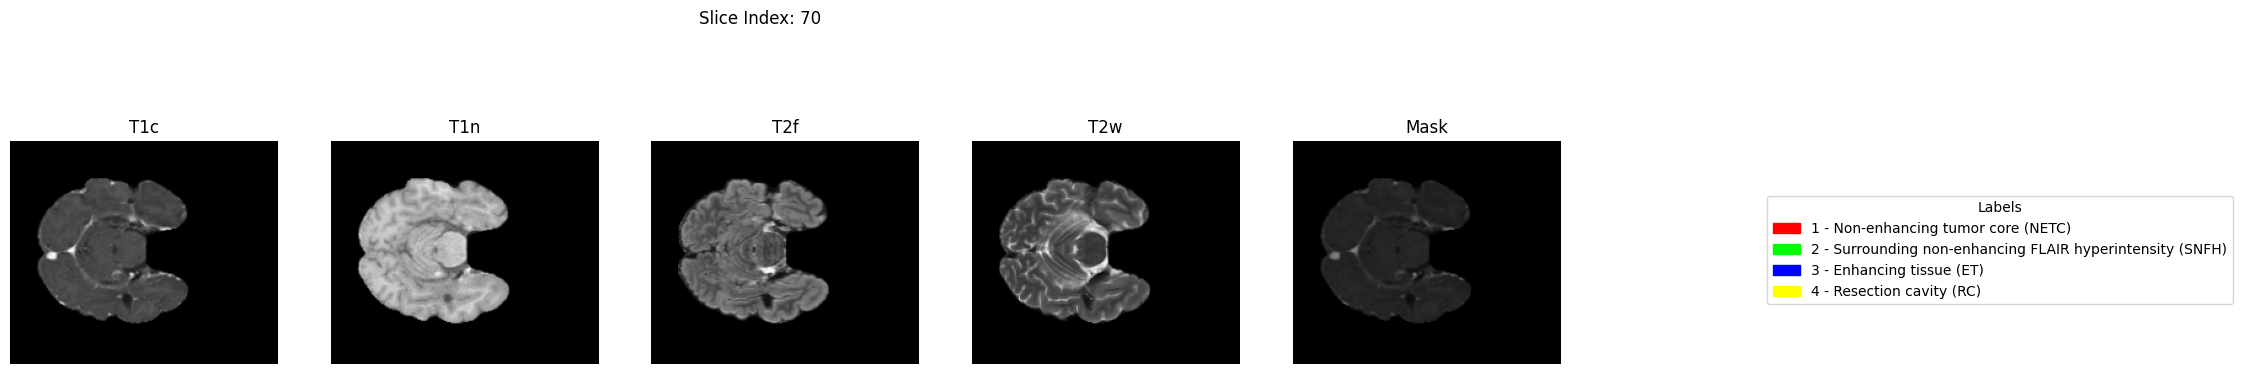

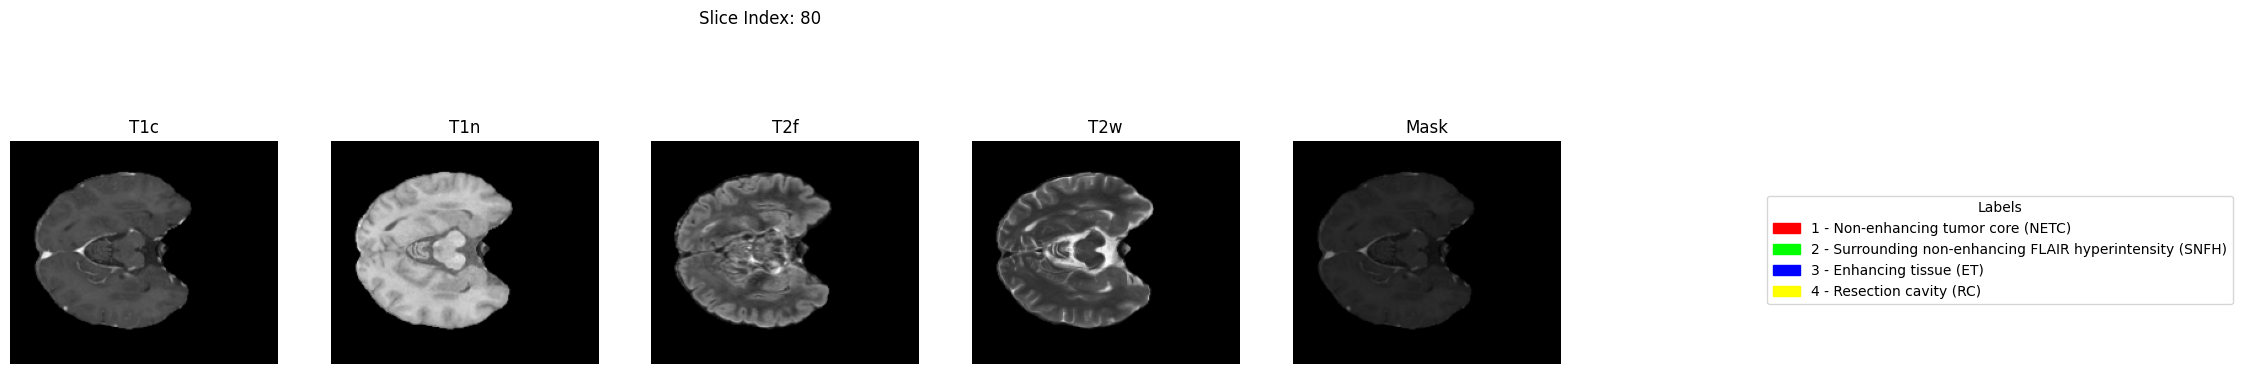

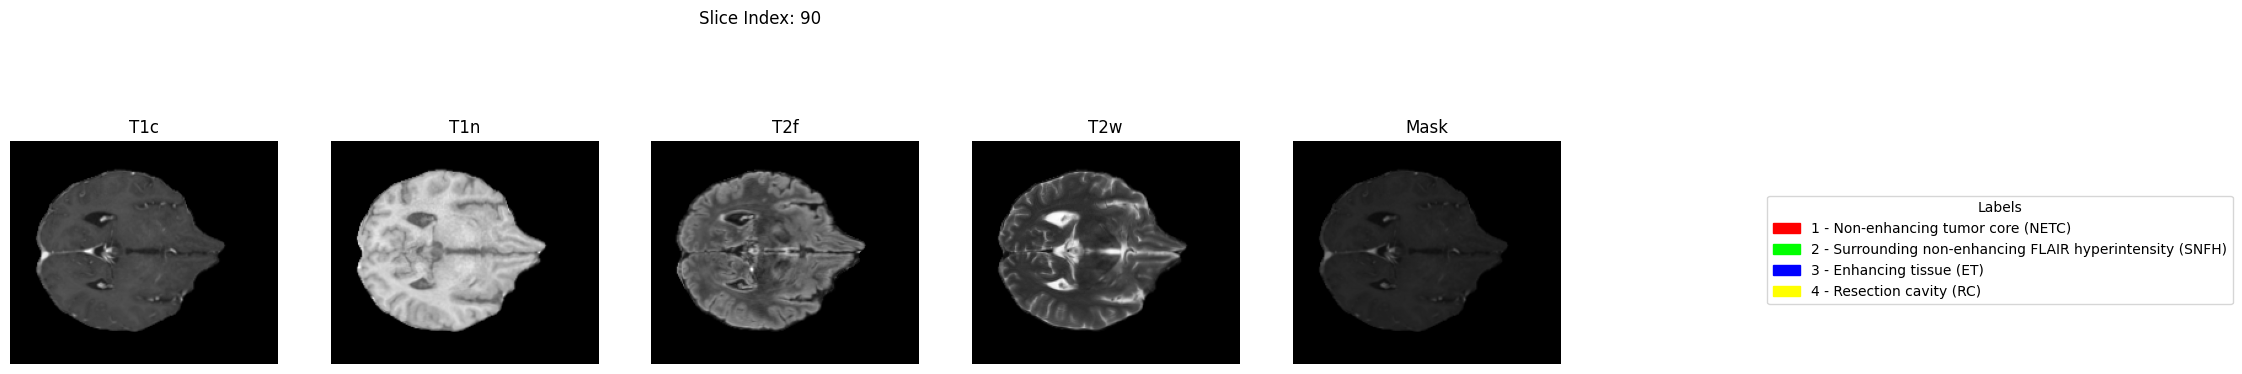

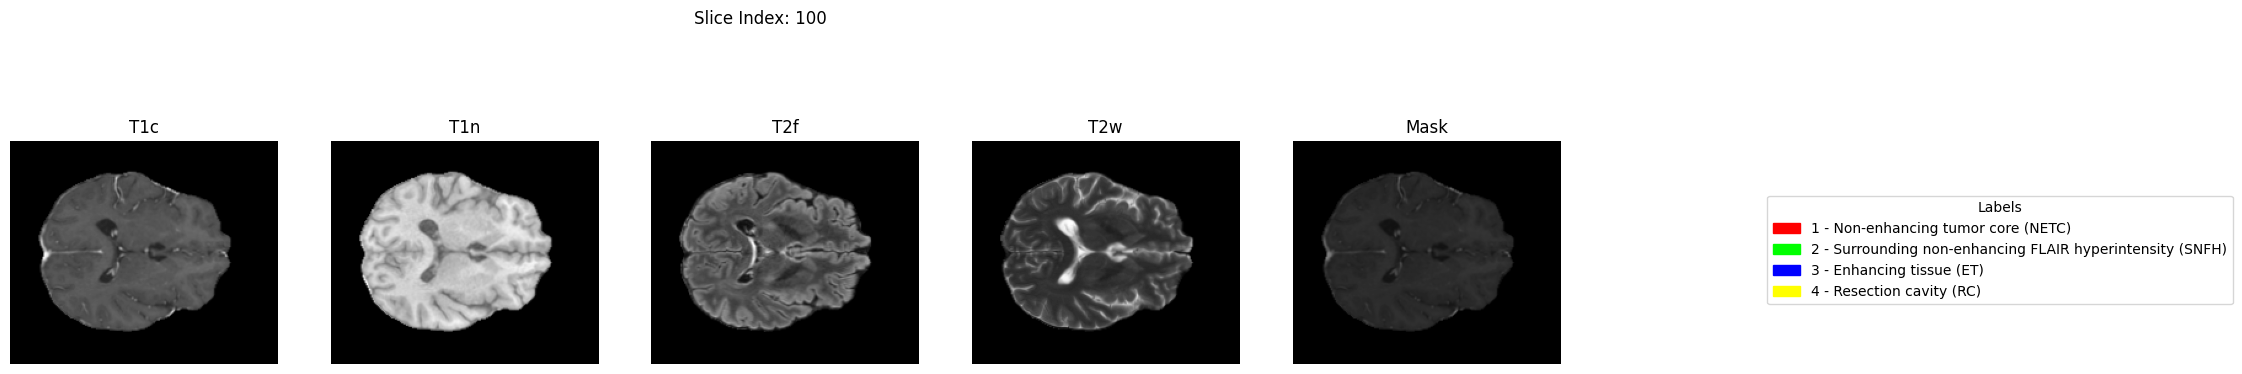

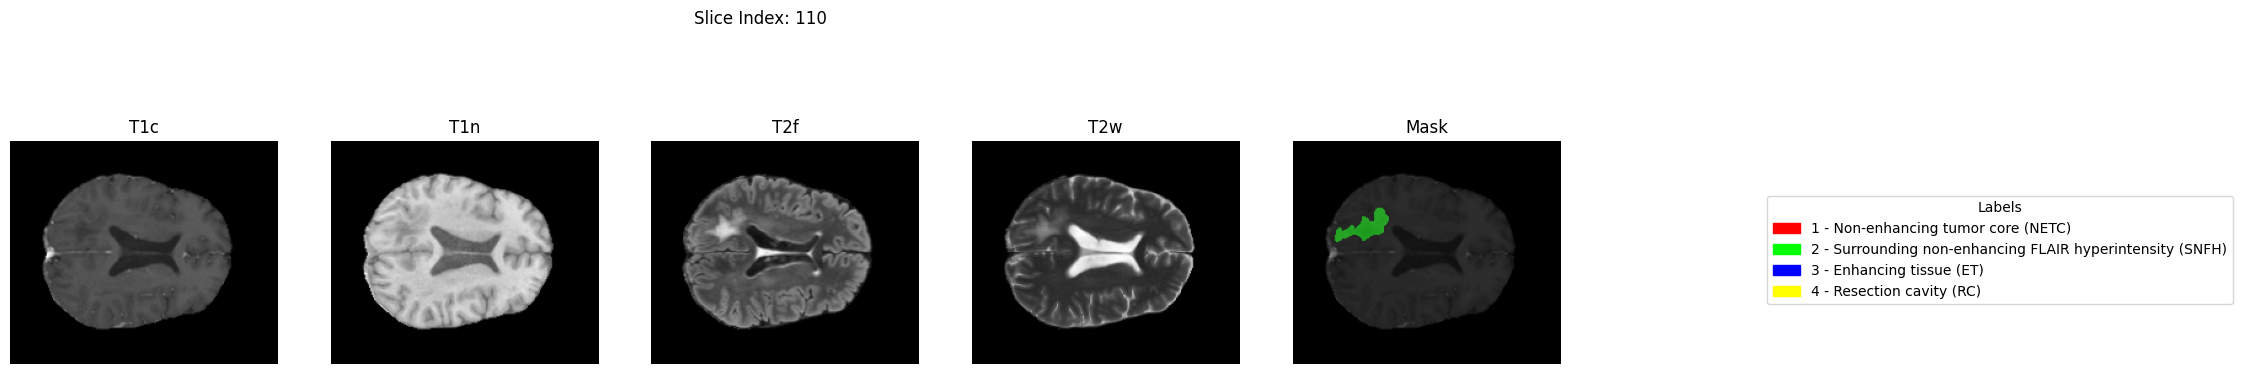

In [9]:
import os
from pathlib import Path
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd
)
from monai.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Define the path to the data directory
root_directory = Path().resolve().parent                            # Main project directory
data_directory = root_directory / 'data' / 'raw' / 'training_data'  # Data directory

# List all subfolders in the data directory
folders = [f for f in data_directory.iterdir() if f.is_dir()]

# Select the first folder for example
first_folder = folders[0]

# Define the paths to the image and mask files
image_files = {
    't1c': str(first_folder / f'{first_folder.name}-t1c.nii.gz'),
    't1n': str(first_folder / f'{first_folder.name}-t1n.nii.gz'),
    't2f': str(first_folder / f'{first_folder.name}-t2f.nii.gz'),
    't2w': str(first_folder / f'{first_folder.name}-t2w.nii.gz'),
    'seg': str(first_folder / f'{first_folder.name}-seg.nii.gz')
}

# Create a list of files to process
files = [{'t1c': image_files['t1c'], 't1n': image_files['t1n'], 't2f': image_files['t2f'], 't2w': image_files['t2w'], 'label': image_files['seg']}]

# Define the transformations
transforms = Compose([
    LoadImaged(keys=['t1c', 't1n', 't2f', 't2w', 'label']),
    EnsureChannelFirstd(keys=['t1c', 't1n', 't2f', 't2w', 'label']),
    ScaleIntensityd(keys=['t1c', 't1n', 't2f', 't2w'])
])

# Create a dataset and dataloader
dataset = Dataset(data=files, transform=transforms)
loader = DataLoader(dataset, batch_size=1)

# Load a sample batch
batch = next(iter(loader))

# Extract image and label data
images = {key: batch[key][0][0] for key in ['t1c', 't1n', 't2f', 't2w']}
label = batch['label'][0][0]

# Define the color map for labels
label_colors = {
    0: [0, 0, 0],         # Background
    1: [255, 0, 0],       # Non-enhancing tumor core (NETC) - Red
    2: [0, 255, 0],       # Surrounding non-enhancing FLAIR hyperintensity (SNFH) - Green
    3: [0, 0, 255],       # Enhancing tissue (ET) - Blue
    4: [255, 255, 0]      # Resection cavity (RC) - Yellow
}

# Labels description
label_descriptions = {
    0: 'Background',
    1: 'Non-enhancing tumor core (NETC)',
    2: 'Surrounding non-enhancing FLAIR hyperintensity (SNFH)',
    3: 'Enhancing tissue (ET)',
    4: 'Resection cavity (RC)'
}

# Function to color the label
def color_label(label, colors):
    colored_label = np.zeros((*label.shape, 3), dtype=np.uint8)
    for lbl, color in colors.items():
        colored_label[label == lbl] = color
    return colored_label

# Function to plot images with a colored label mask
def plot_slices(slice_idx, images, label):
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    modalities = ['t1c', 't1n', 't2f', 't2w']
    titles = ['T1c', 'T1n', 'T2f', 'T2w', 'Mask']
    
    for i, modality in enumerate(modalities):
        axs[i].imshow(images[modality][:, :, slice_idx], cmap='gray', origin='lower')
        axs[i].set_title(titles[i])
        axs[i].axis('off')

    colored_label = color_label(label[:, :, slice_idx], label_colors)
    axs[4].imshow(images['t1c'][:, :, slice_idx], cmap='gray', origin='lower')
    axs[4].imshow(colored_label, alpha=0.5, origin='lower')
    axs[4].set_title(titles[4])
    axs[4].axis('off')

    # Add a legend
    handles = [mpatches.Patch(color=np.array(color)/255, label=f"{lbl} - {label_descriptions[lbl]}") for lbl, color in label_colors.items() if lbl != 0]
    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Labels")
    
    plt.suptitle(f"Slice Index: {slice_idx}")
    plt.show()

for i in range(50, images['t1c'].shape[2]-40, 10):
    plot_slices(i, images, label)
